In [1]:
from scipy import stats 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Epydemix import
import sys 
sys.path.append("../")
from epydemix.population import Population
from epydemix.epimodel import EpiModel, stochastic_simulation
from epydemix.plotting import plot_quantiles, plot_selected_quantiles, plot_posterior, plot_posterior_2d
from epydemix.calibration import calibration_top_perc

# Calibration

Import population data:

In [2]:
population = Population() 
population.load_population(population_name="Indonesia", path_to_data="../epydemix_data/")

Import epidemiological data:

In [3]:
df_I = pd.read_csv("./data/data_I.csv")
df_I.head()

,I,date
0,15,2019-12-01
1,16,2019-12-02
2,21,2019-12-03
3,29,2019-12-04
4,38,2019-12-05


In [5]:
# create model 
model = EpiModel(compartments=["S", "I", "R"])
model.add_parameters({"bet": 0.02, "mu": 0.2})
model.add_transition(source="S", target="I", rate_name="bet", agent="I")
model.add_transition(source="I", target="R", rate_name="mu")

# initial conditions
S=population.Nk - np.ones(len(population.Nk))
I=np.ones(len(population.Nk))
R=np.zeros(len(population.Nk))

# simulation dates
steps = "daily"
start_date=df_I.date.values[0]
end_date=df_I.date.values[-1]
start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
simulation_dates = pd.date_range(start=start_date, end=end_date, freq="d").tolist()
model.compute_contact_reductions(population, simulation_dates)

# parameters
parameters = {"Cs": model.Cs, 
              "Nk": population.Nk, 
              "S": S, 
              "I": I, 
              "R": R, 
              "epimodel": model, 
              "dt": np.diff(simulation_dates)[0] / timedelta(days=1),
              "population": population, 
              "simulation_dates": simulation_dates}
parameters.update(model.parameters)

In [6]:
def post_processing_function(results, **parameters): 
    results.update({"data": results["I_total"]})
    return results

results = calibration_top_perc(simulation_function=stochastic_simulation, 
                               parameters=parameters,
                               priors={"bet": stats.uniform(0.015, 0.025), 
                                       "mu": stats.uniform(0.15, 0.25)}, 
                               data={"data": df_I["I"].values},
                               top_perc=0.05,
                               Nsim=1000,
                               post_processing_function=post_processing_function)

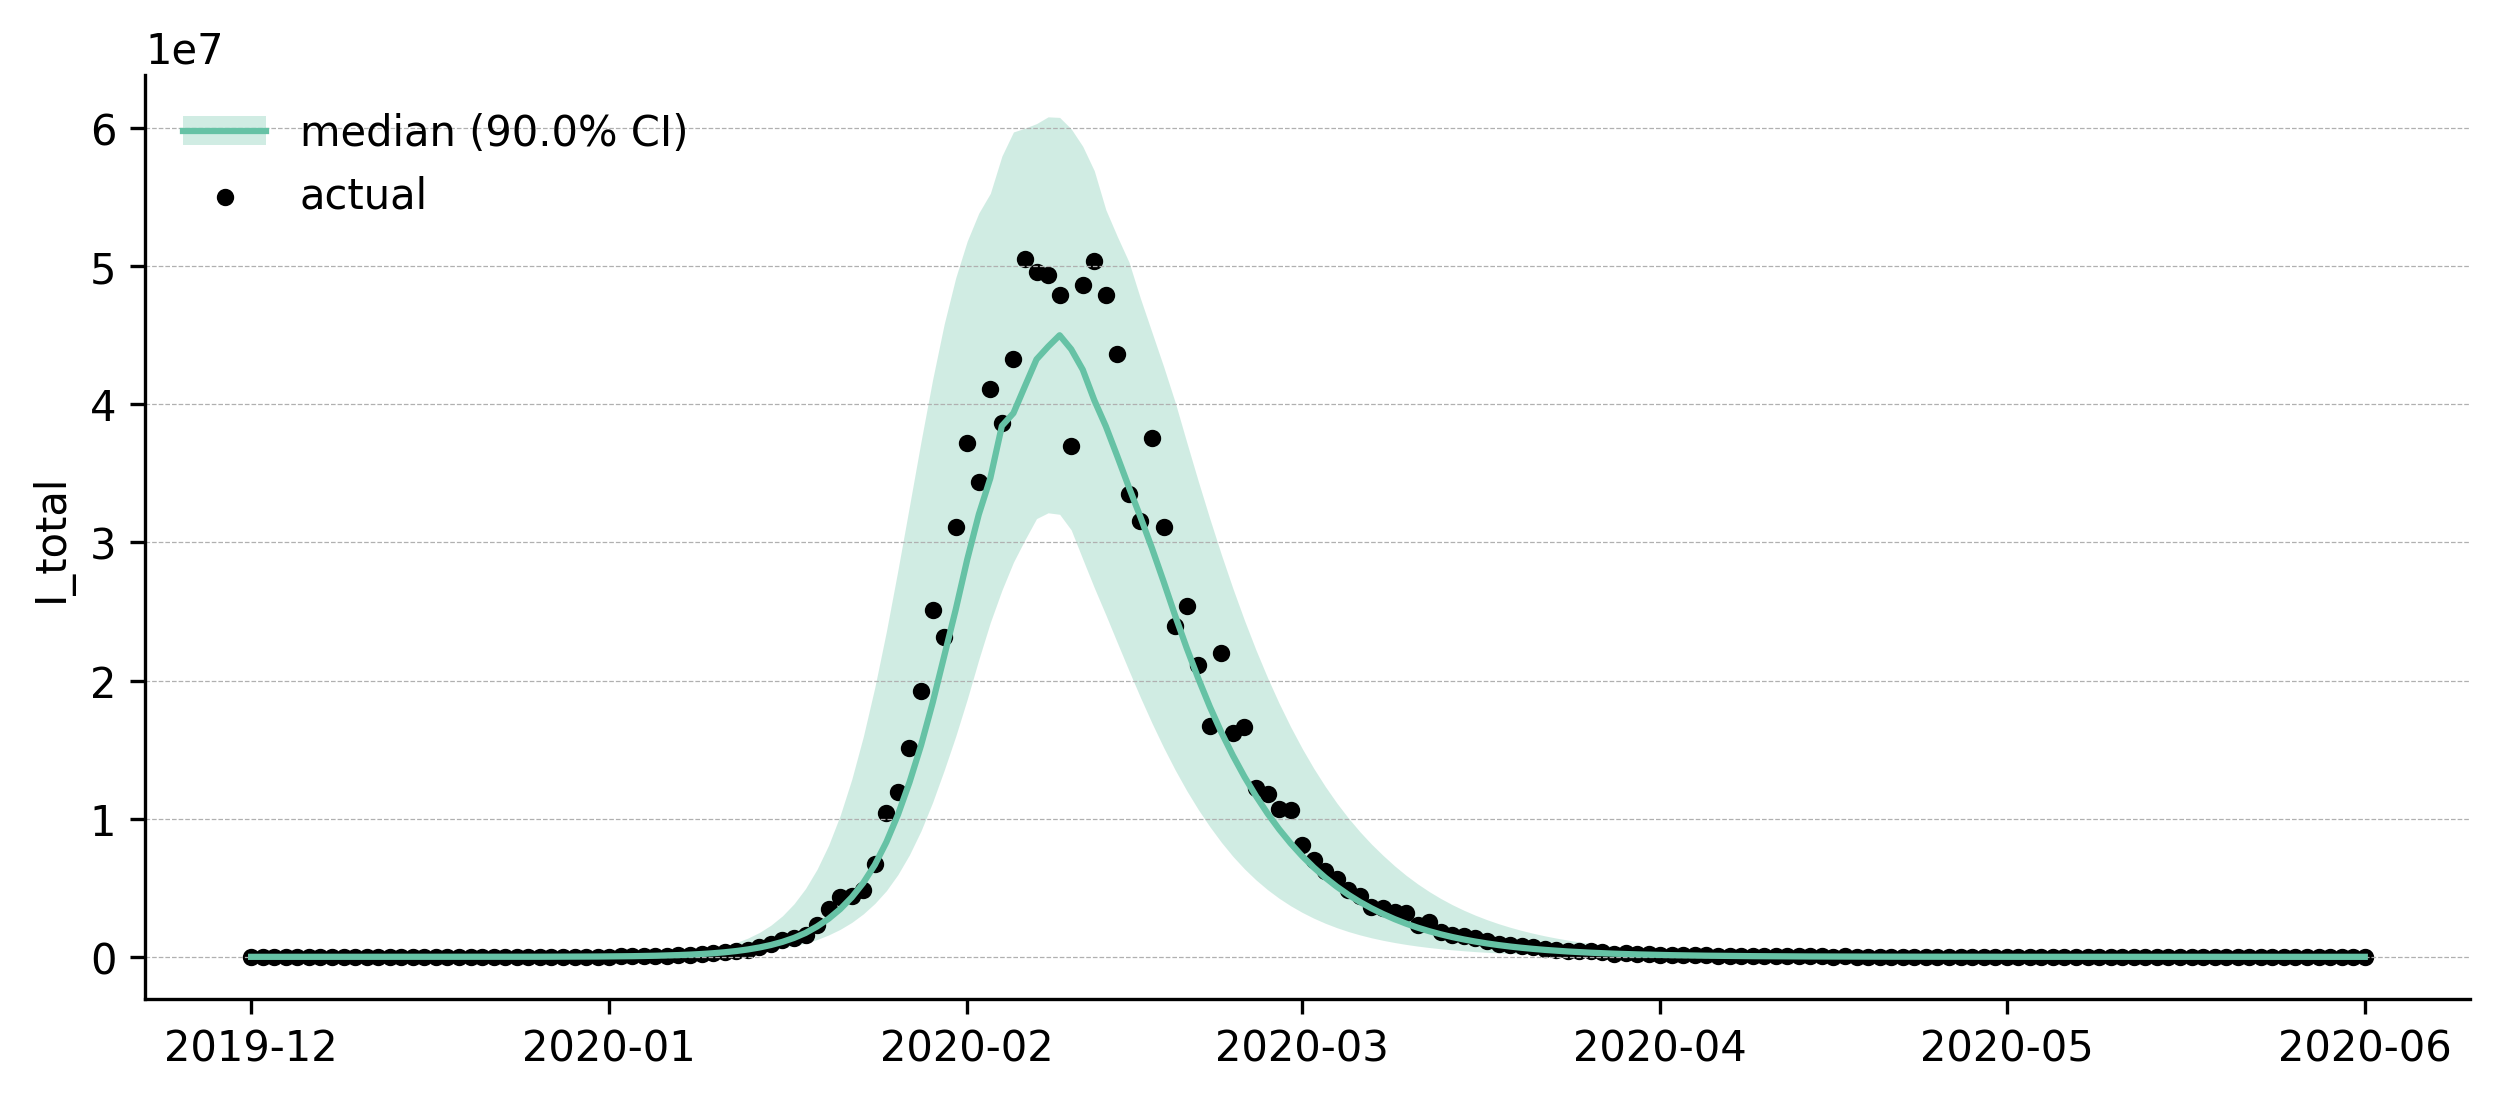

In [7]:
plot_selected_quantiles(results, ylabel="I_total")

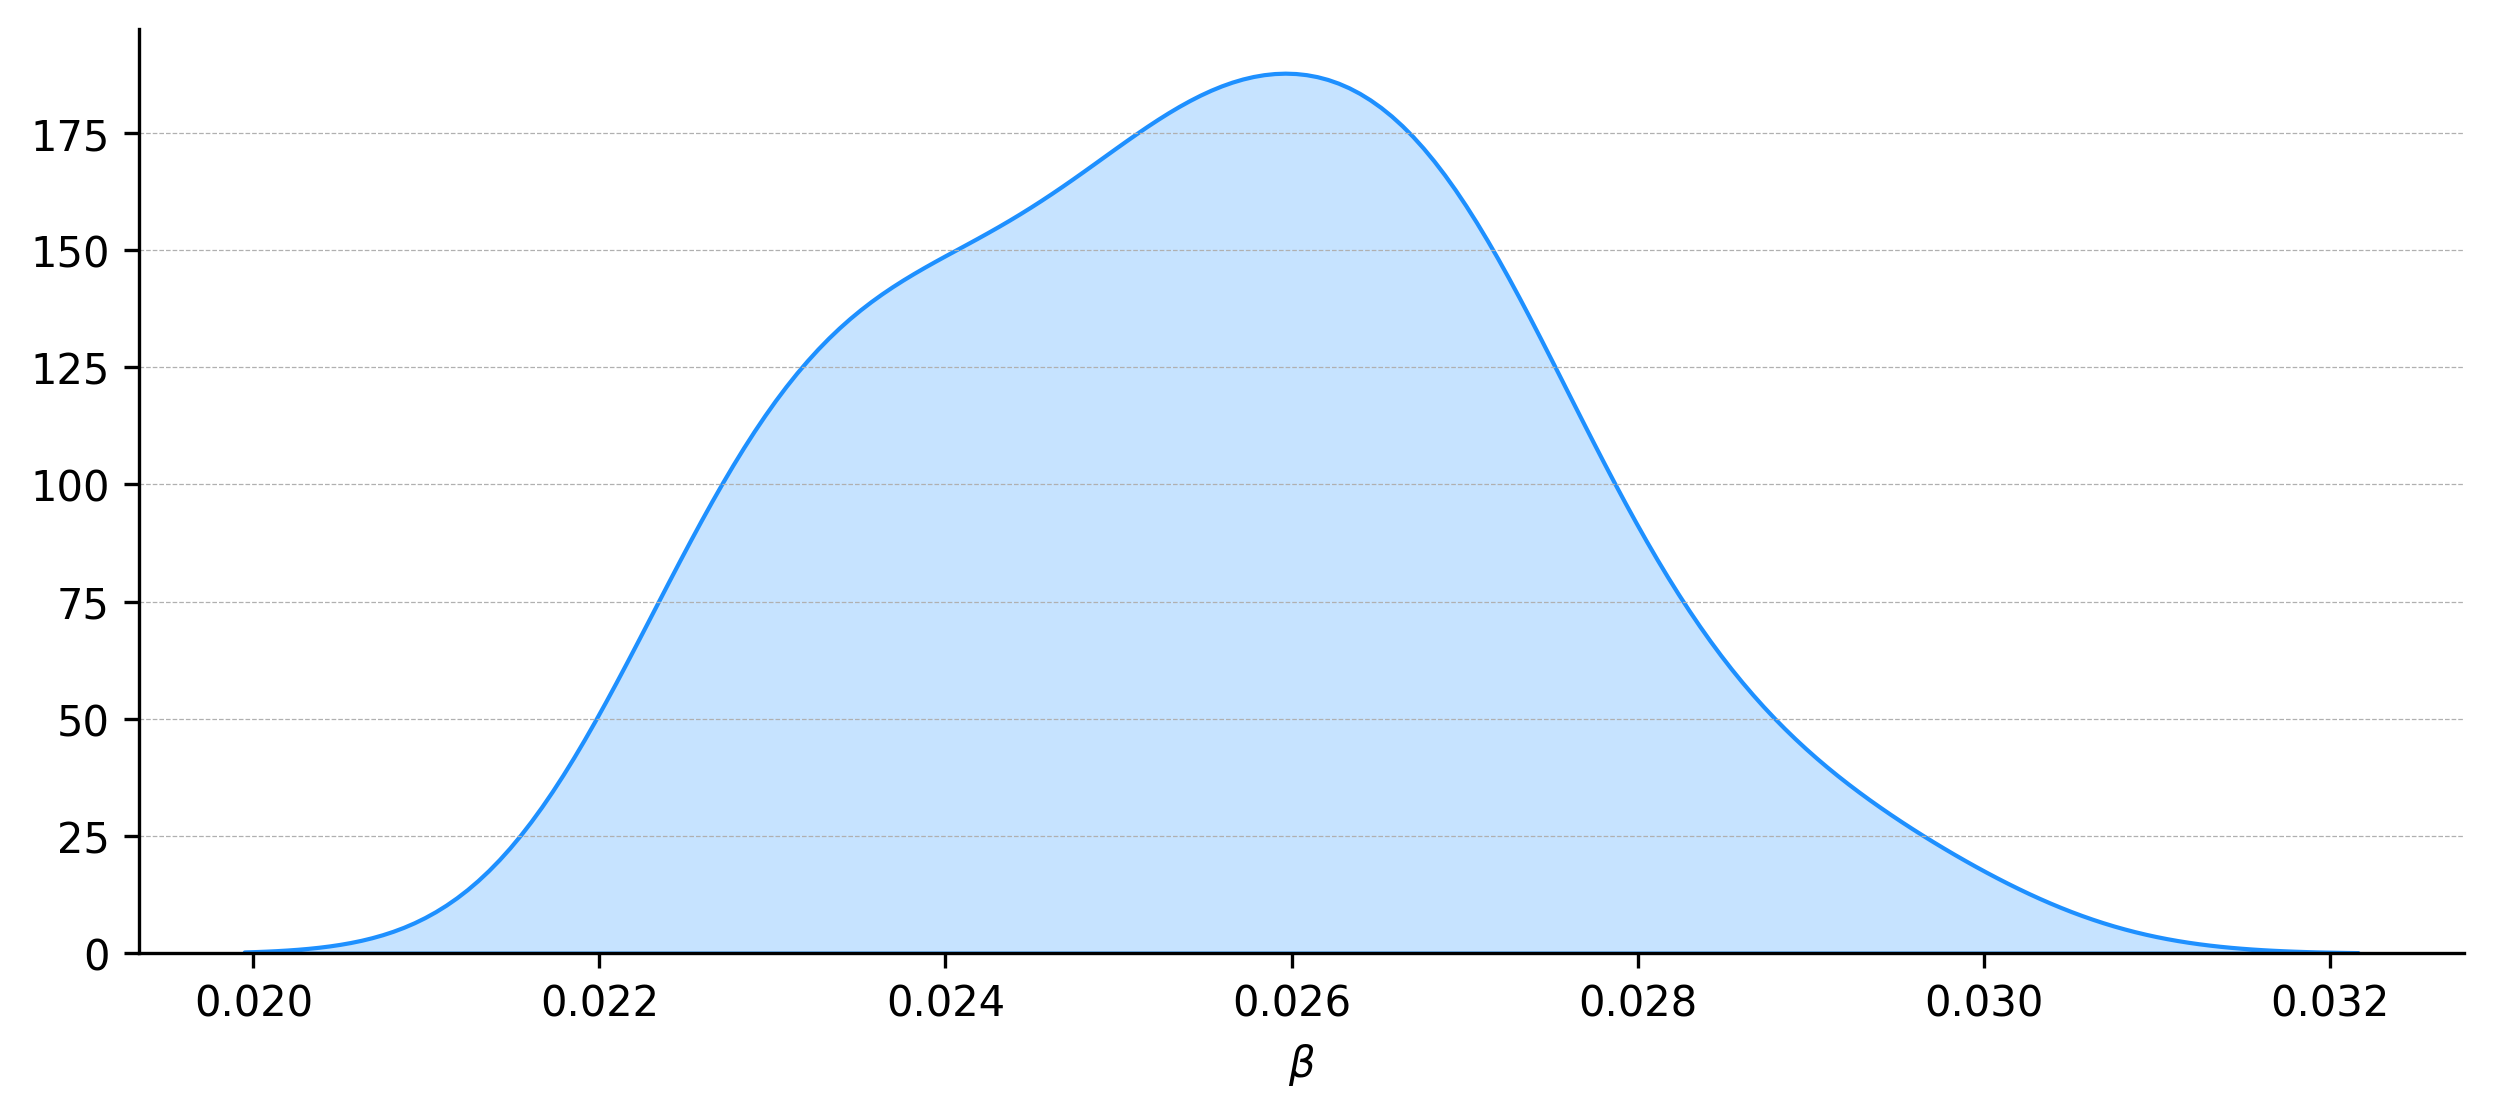

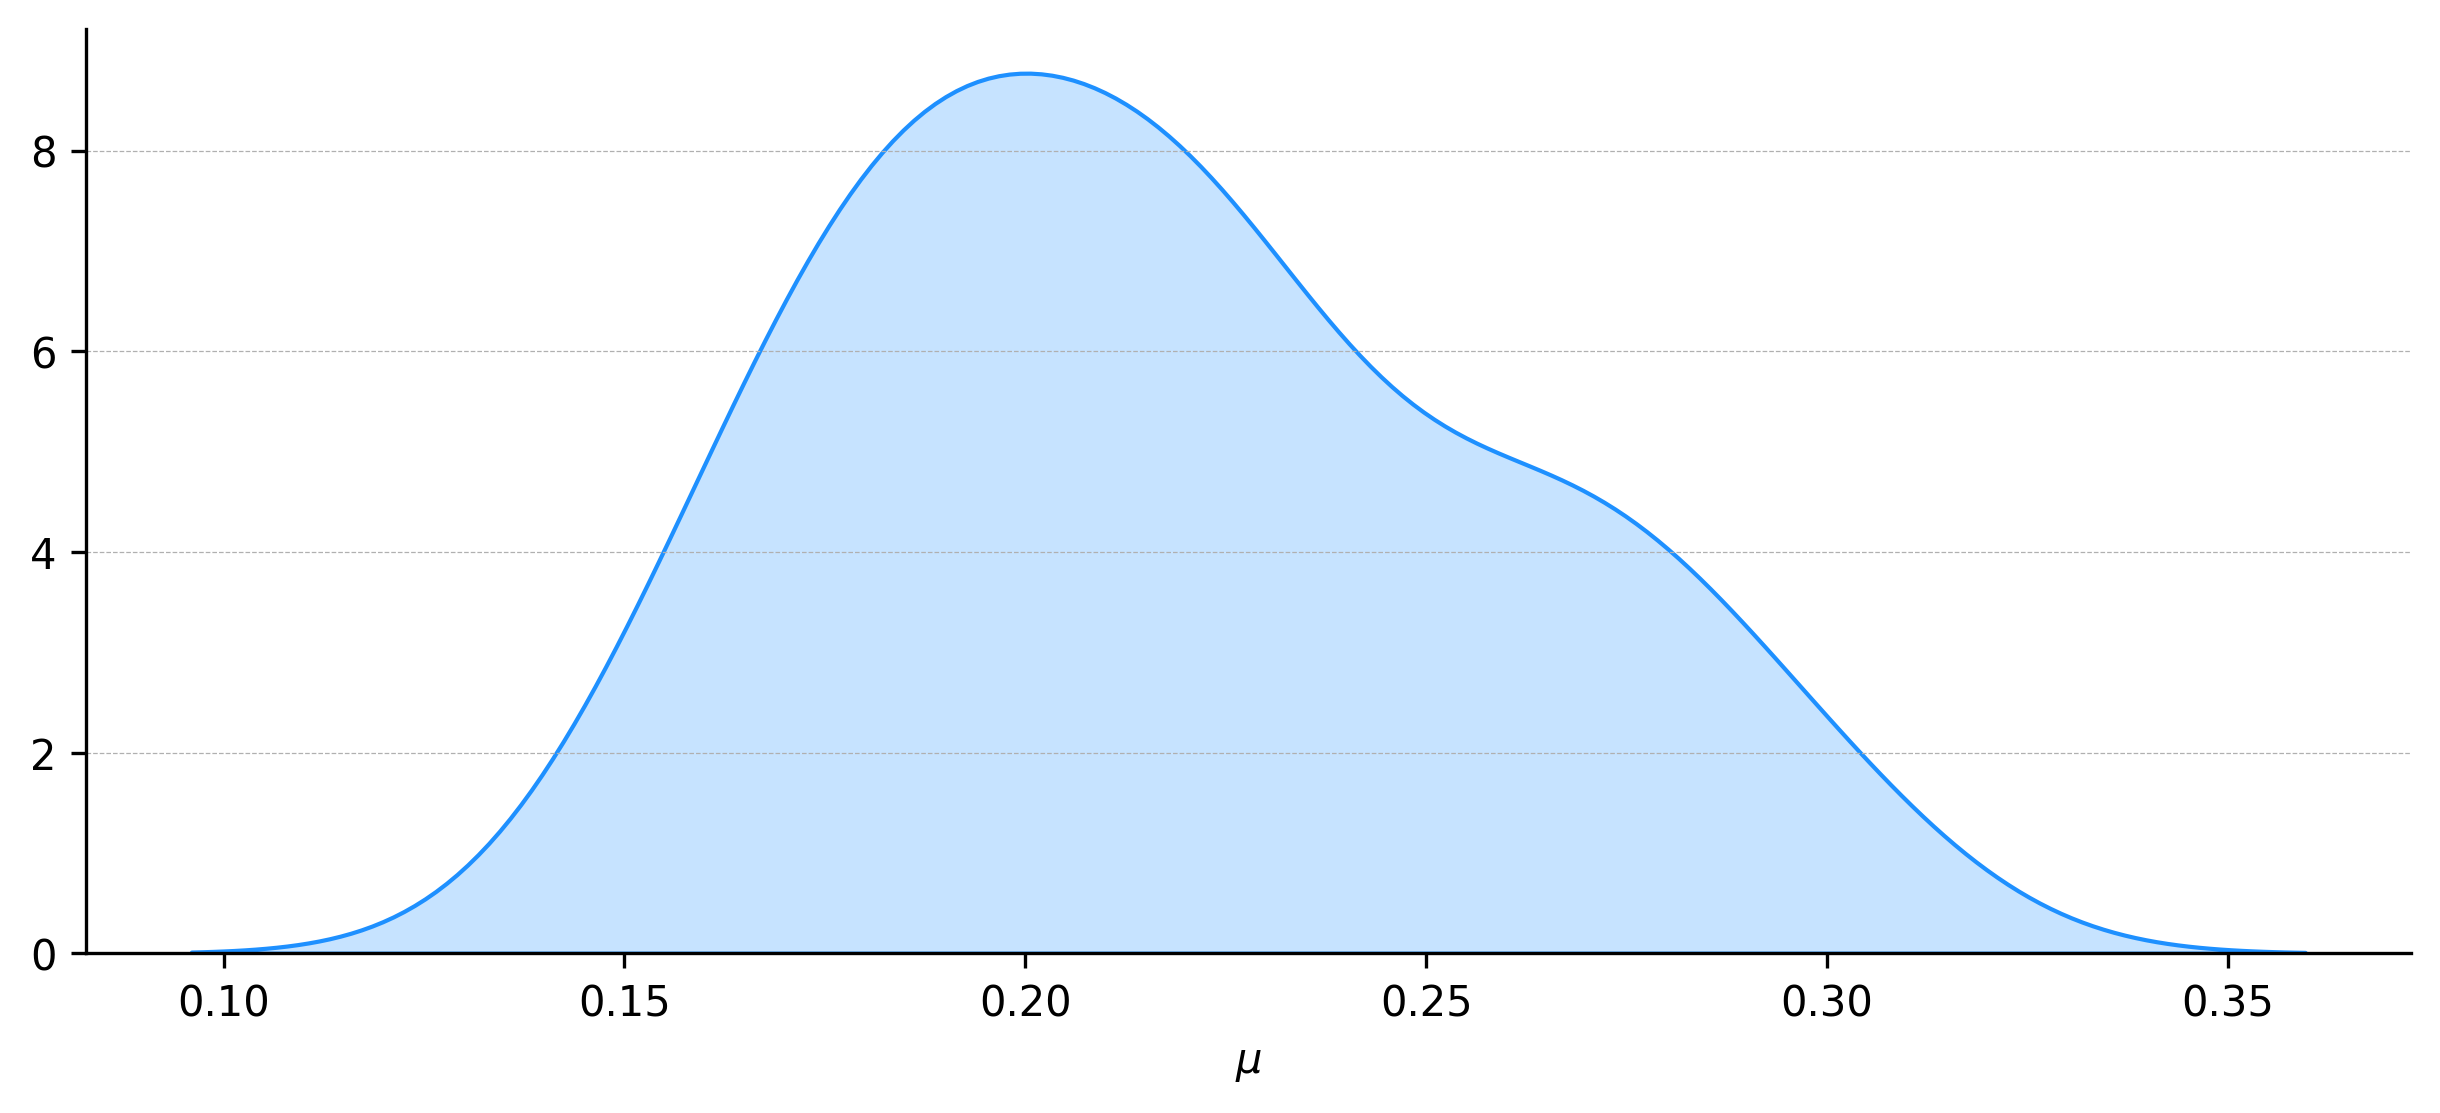

In [11]:
plot_posterior(results, "bet", kind="kde", prior_range=False, xlabel="$\\beta$")
plot_posterior(results, "mu", kind="kde", prior_range=False, xlabel="$\\mu$")

../epydemix/plotting.py:217: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df_posterior, x=parameter_x, y=parameter_y, ax=ax, fill=True, palette=palette, **kwargs)


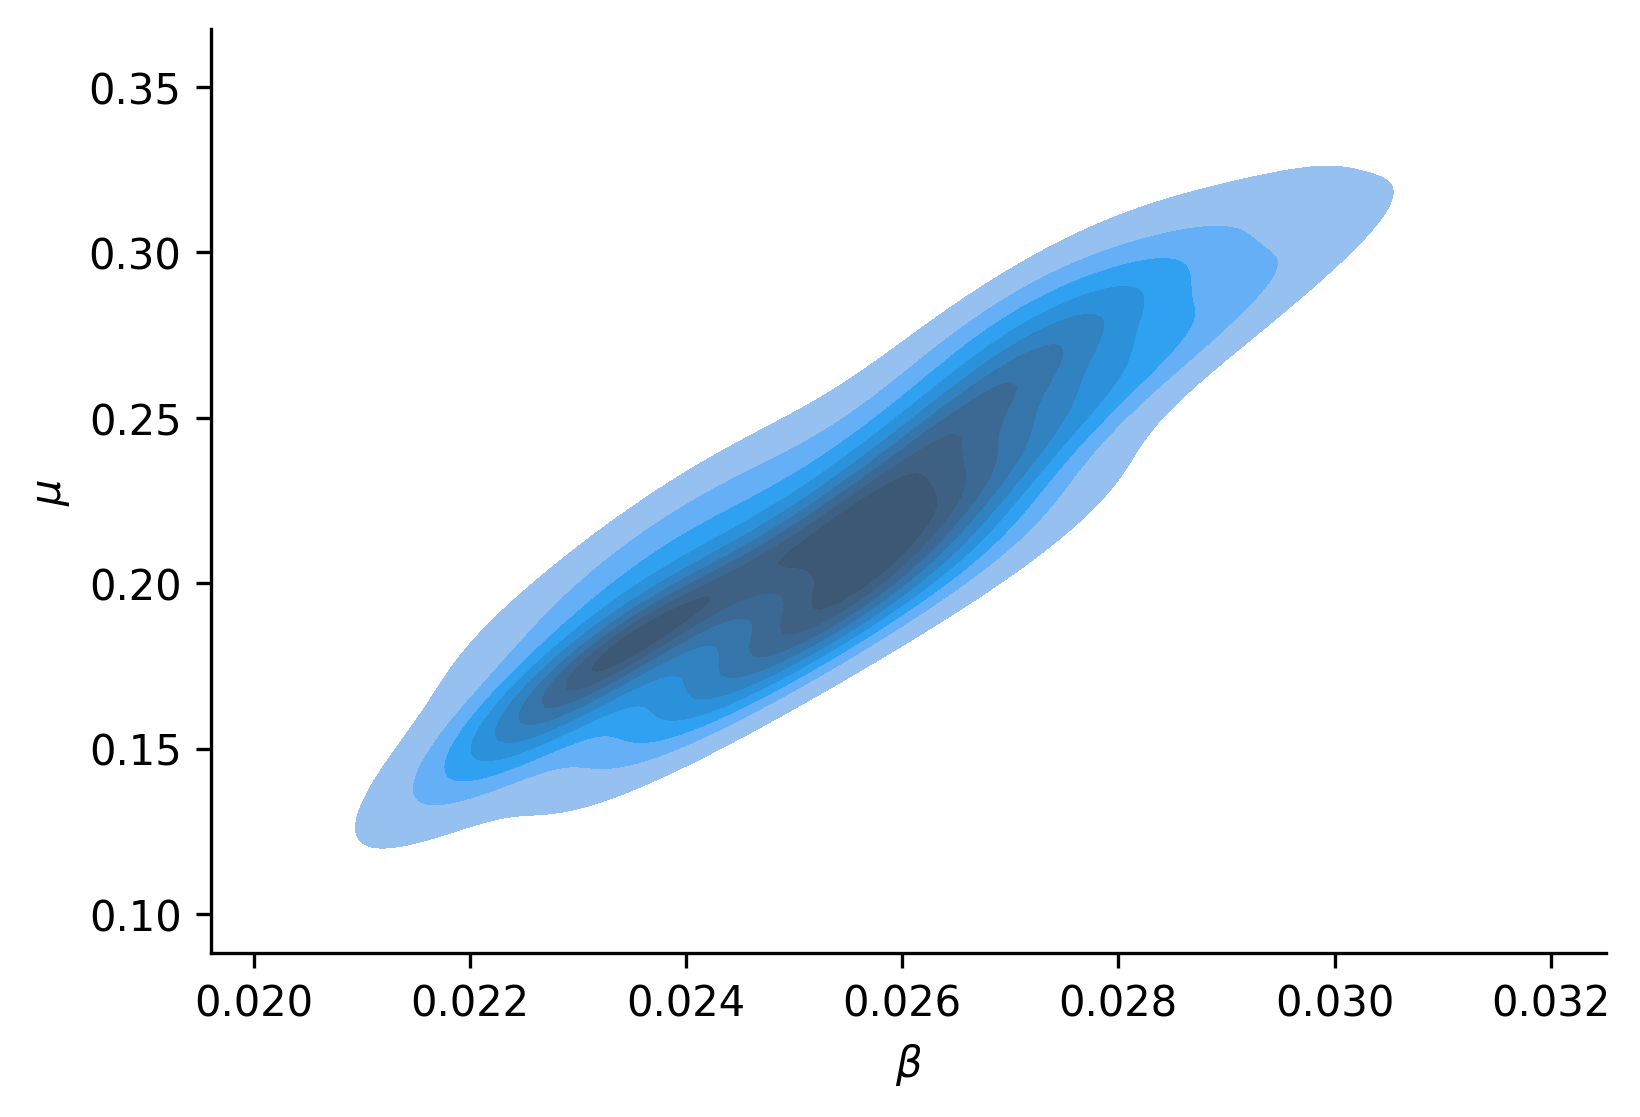

In [10]:
plot_posterior_2d(results, "bet", "mu", kind="kde", prior_range=False, xlabel="$\\beta$", ylabel="$\\mu$")

# Incidence example

In [13]:
df_incidence = pd.read_csv("./data/data_incidence.csv")
df_incidence.head()

,incidence,date
0,0,2019-12-01
1,7,2019-12-02
2,7,2019-12-03
3,9,2019-12-04
4,10,2019-12-05


In [14]:
def post_processing_function(results, **parameters): 
    results.update({"data": np.concatenate(([0], (np.abs(np.diff(results["S_total"])))))})
    return results

results = calibration_top_perc(simulation_function=stochastic_simulation, 
                               parameters=parameters,
                               priors={"bet": stats.uniform(0.015, 0.025), 
                                       "mu": stats.uniform(0.15, 0.25)}, 
                               data={"data": df_incidence["incidence"].values},
                               top_perc=0.05,
                               Nsim=1000,
                               post_processing_function=post_processing_function)

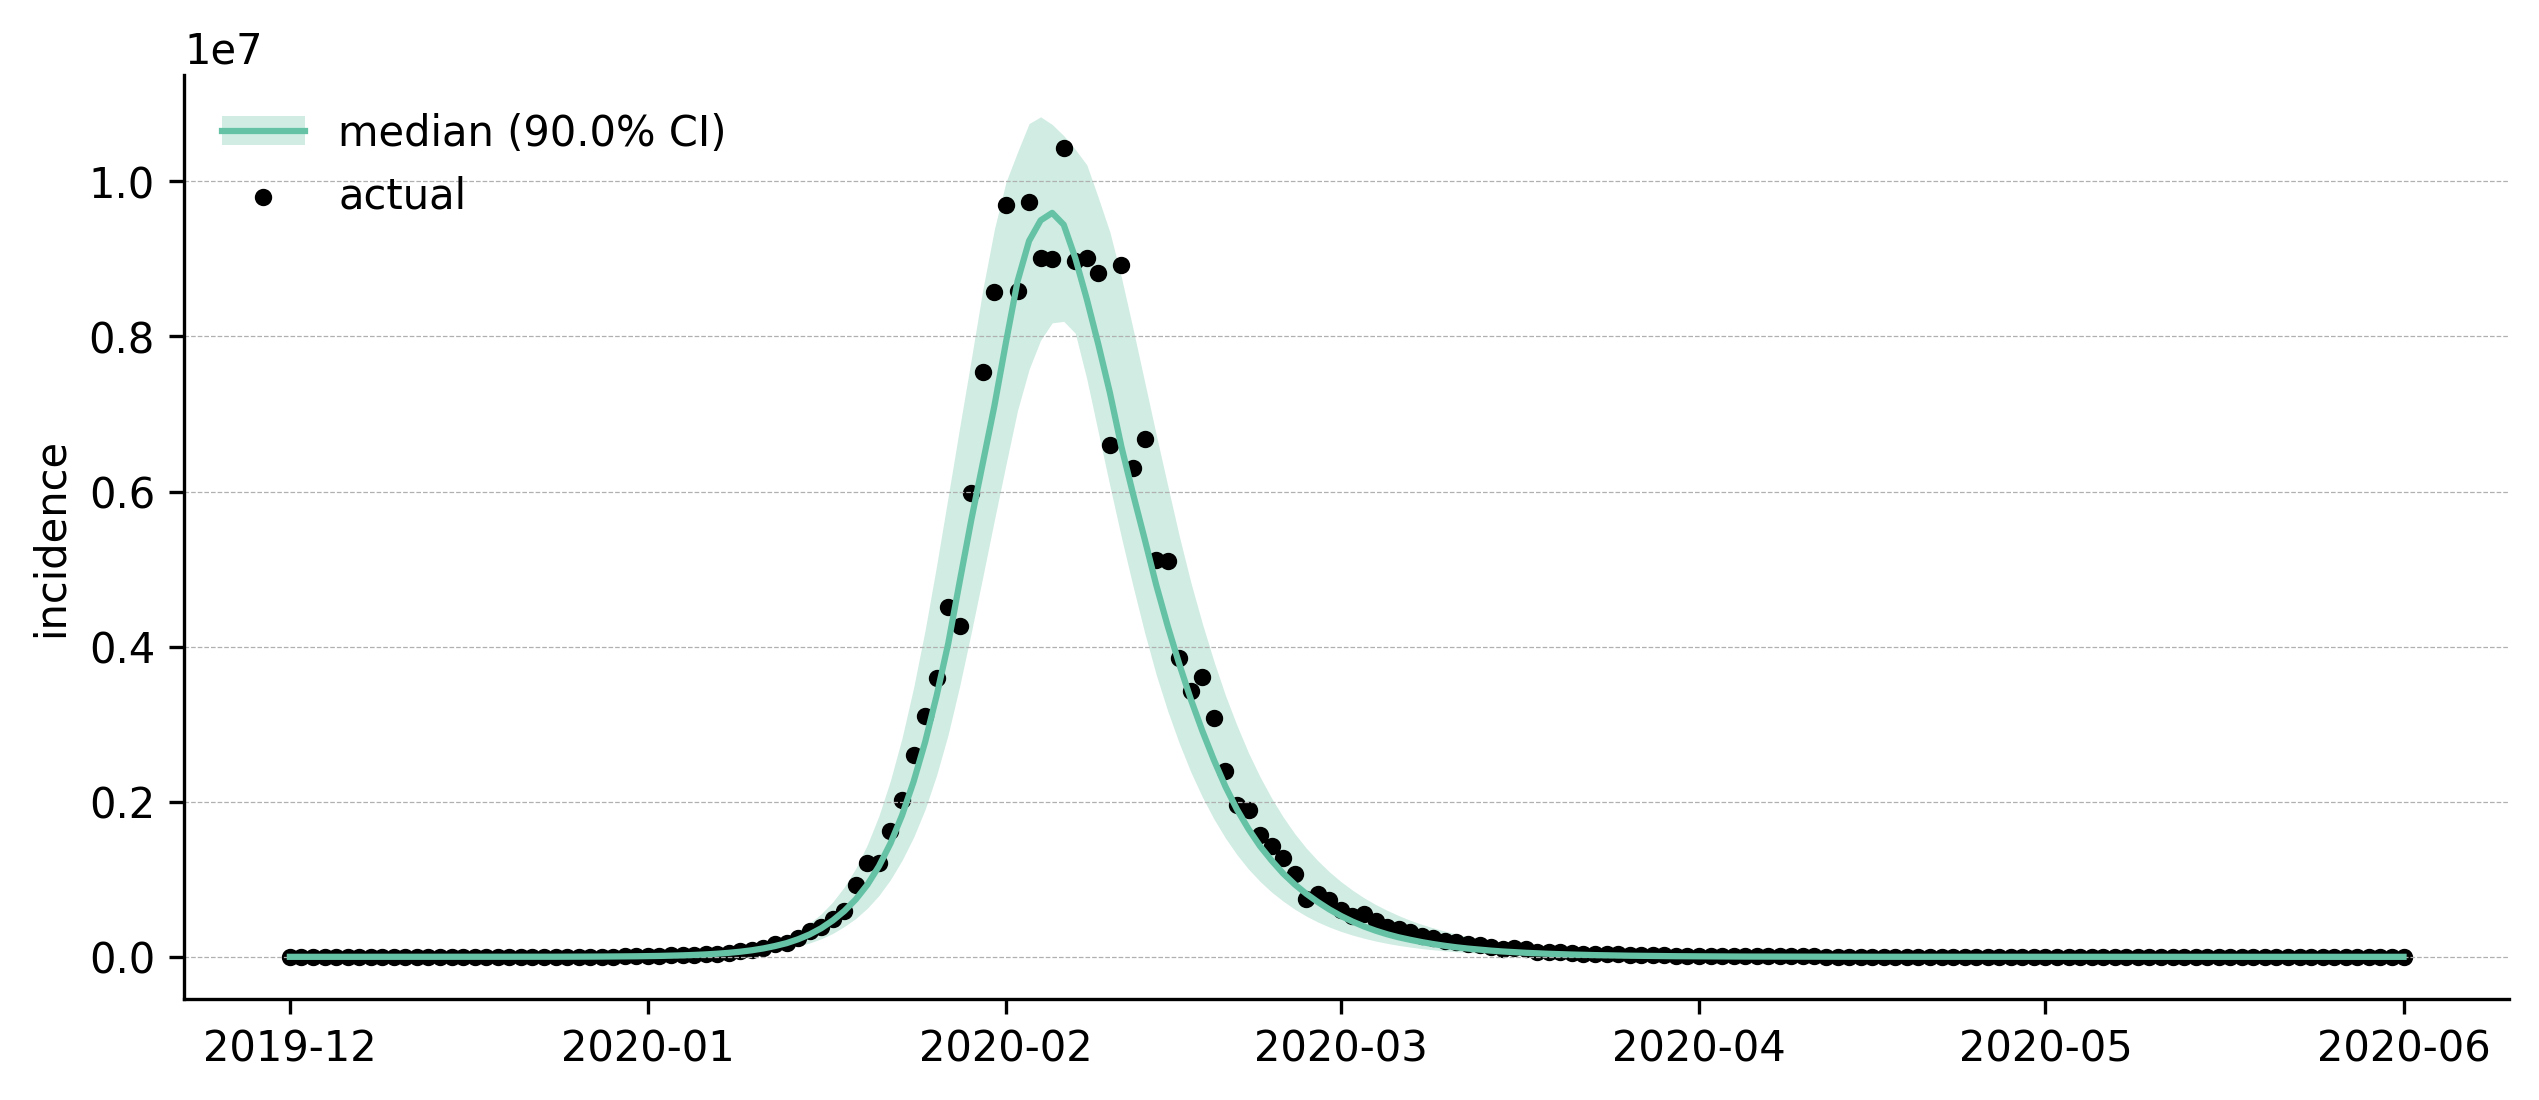

In [15]:
plot_selected_quantiles(results, ylabel="incidence")

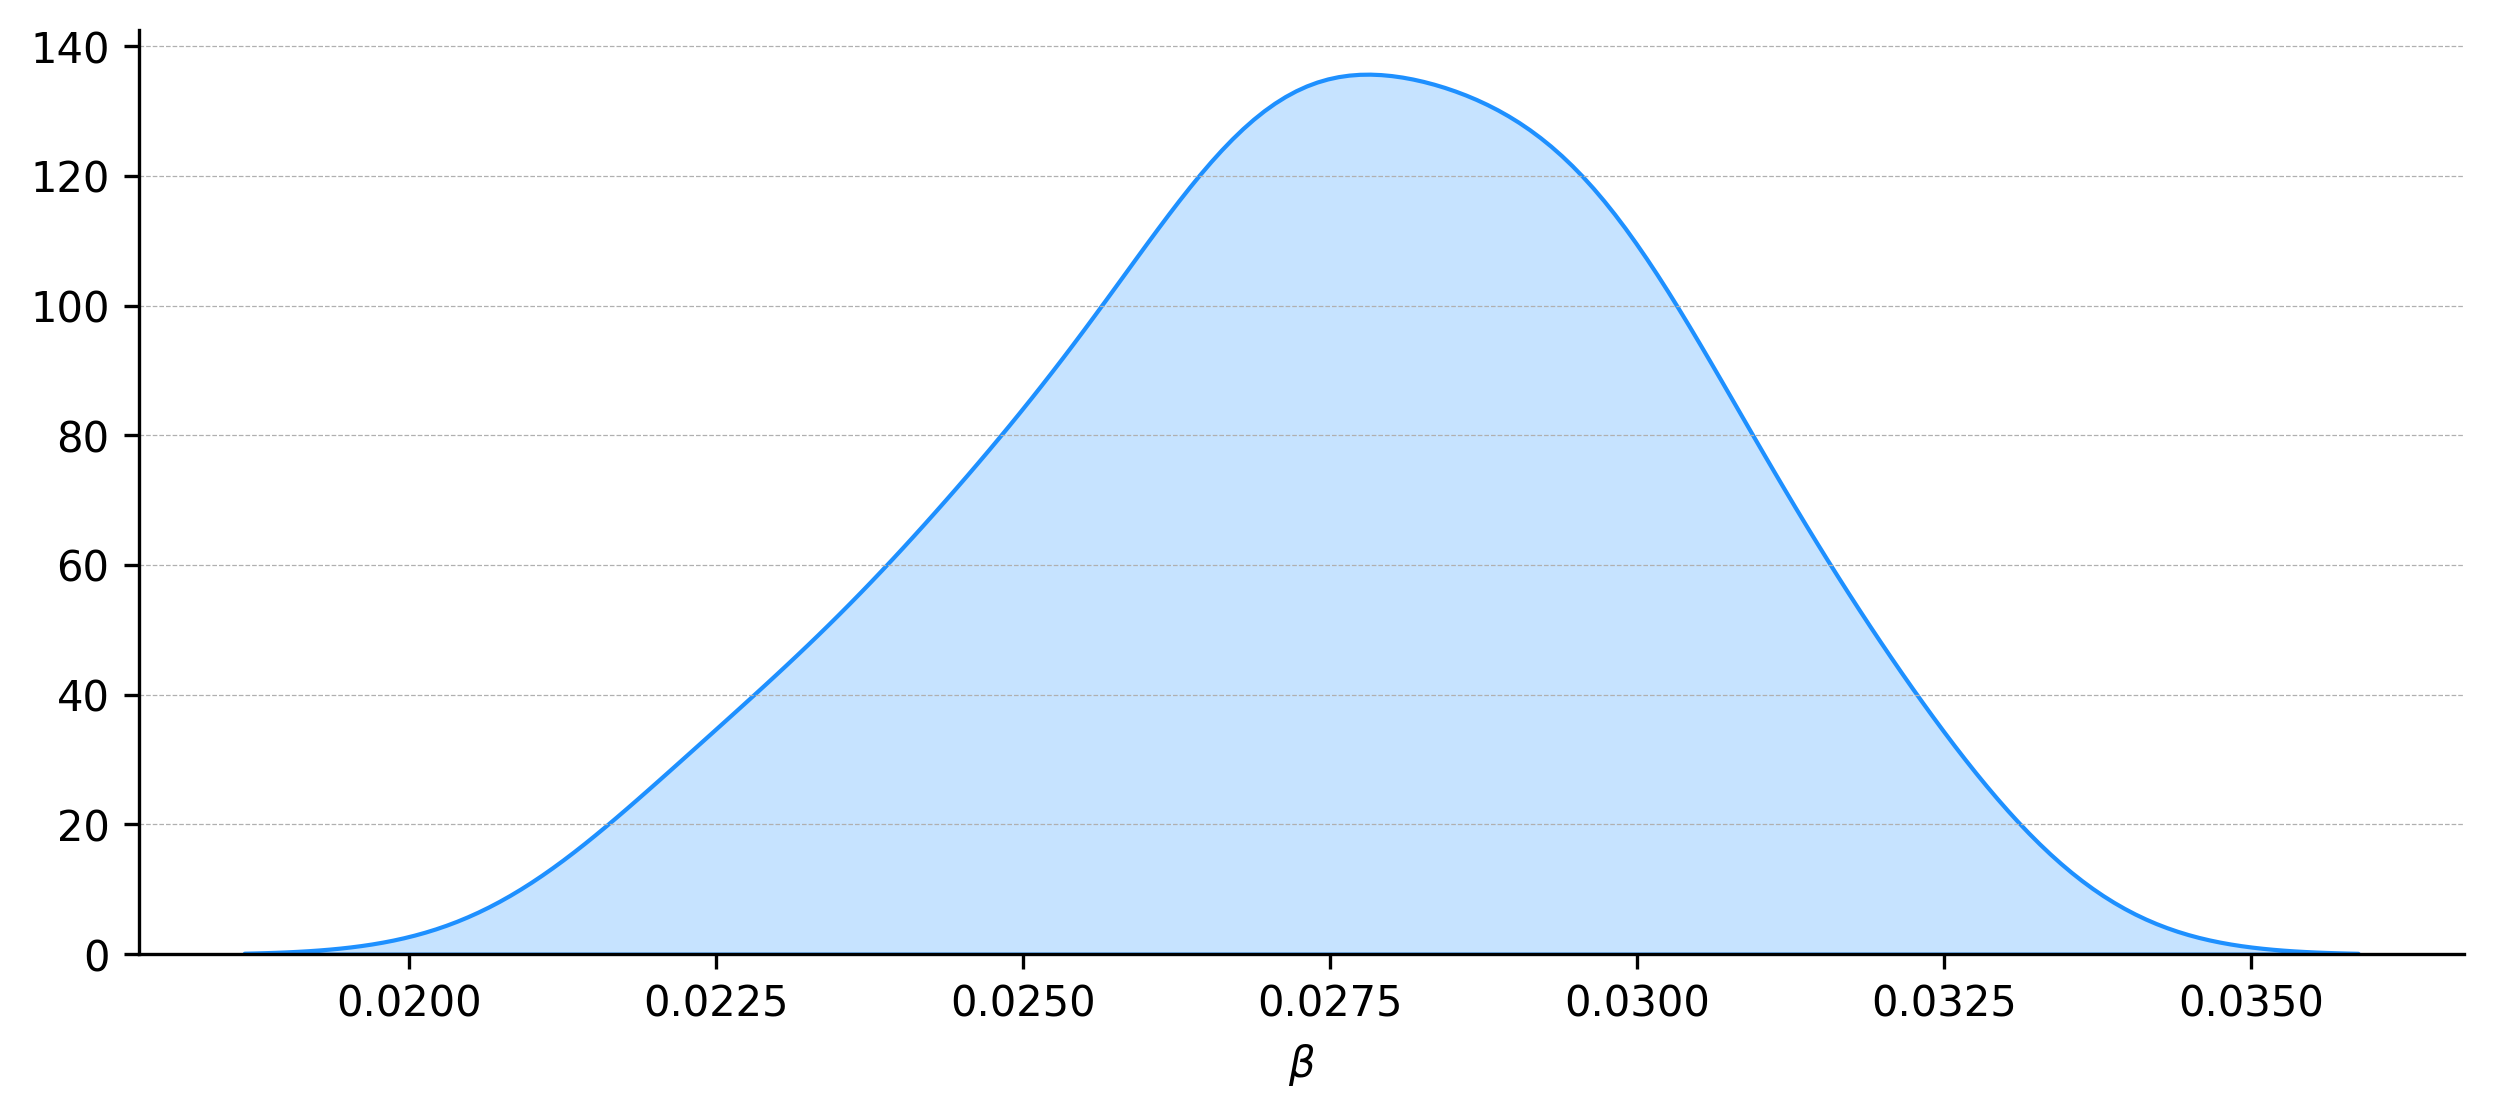

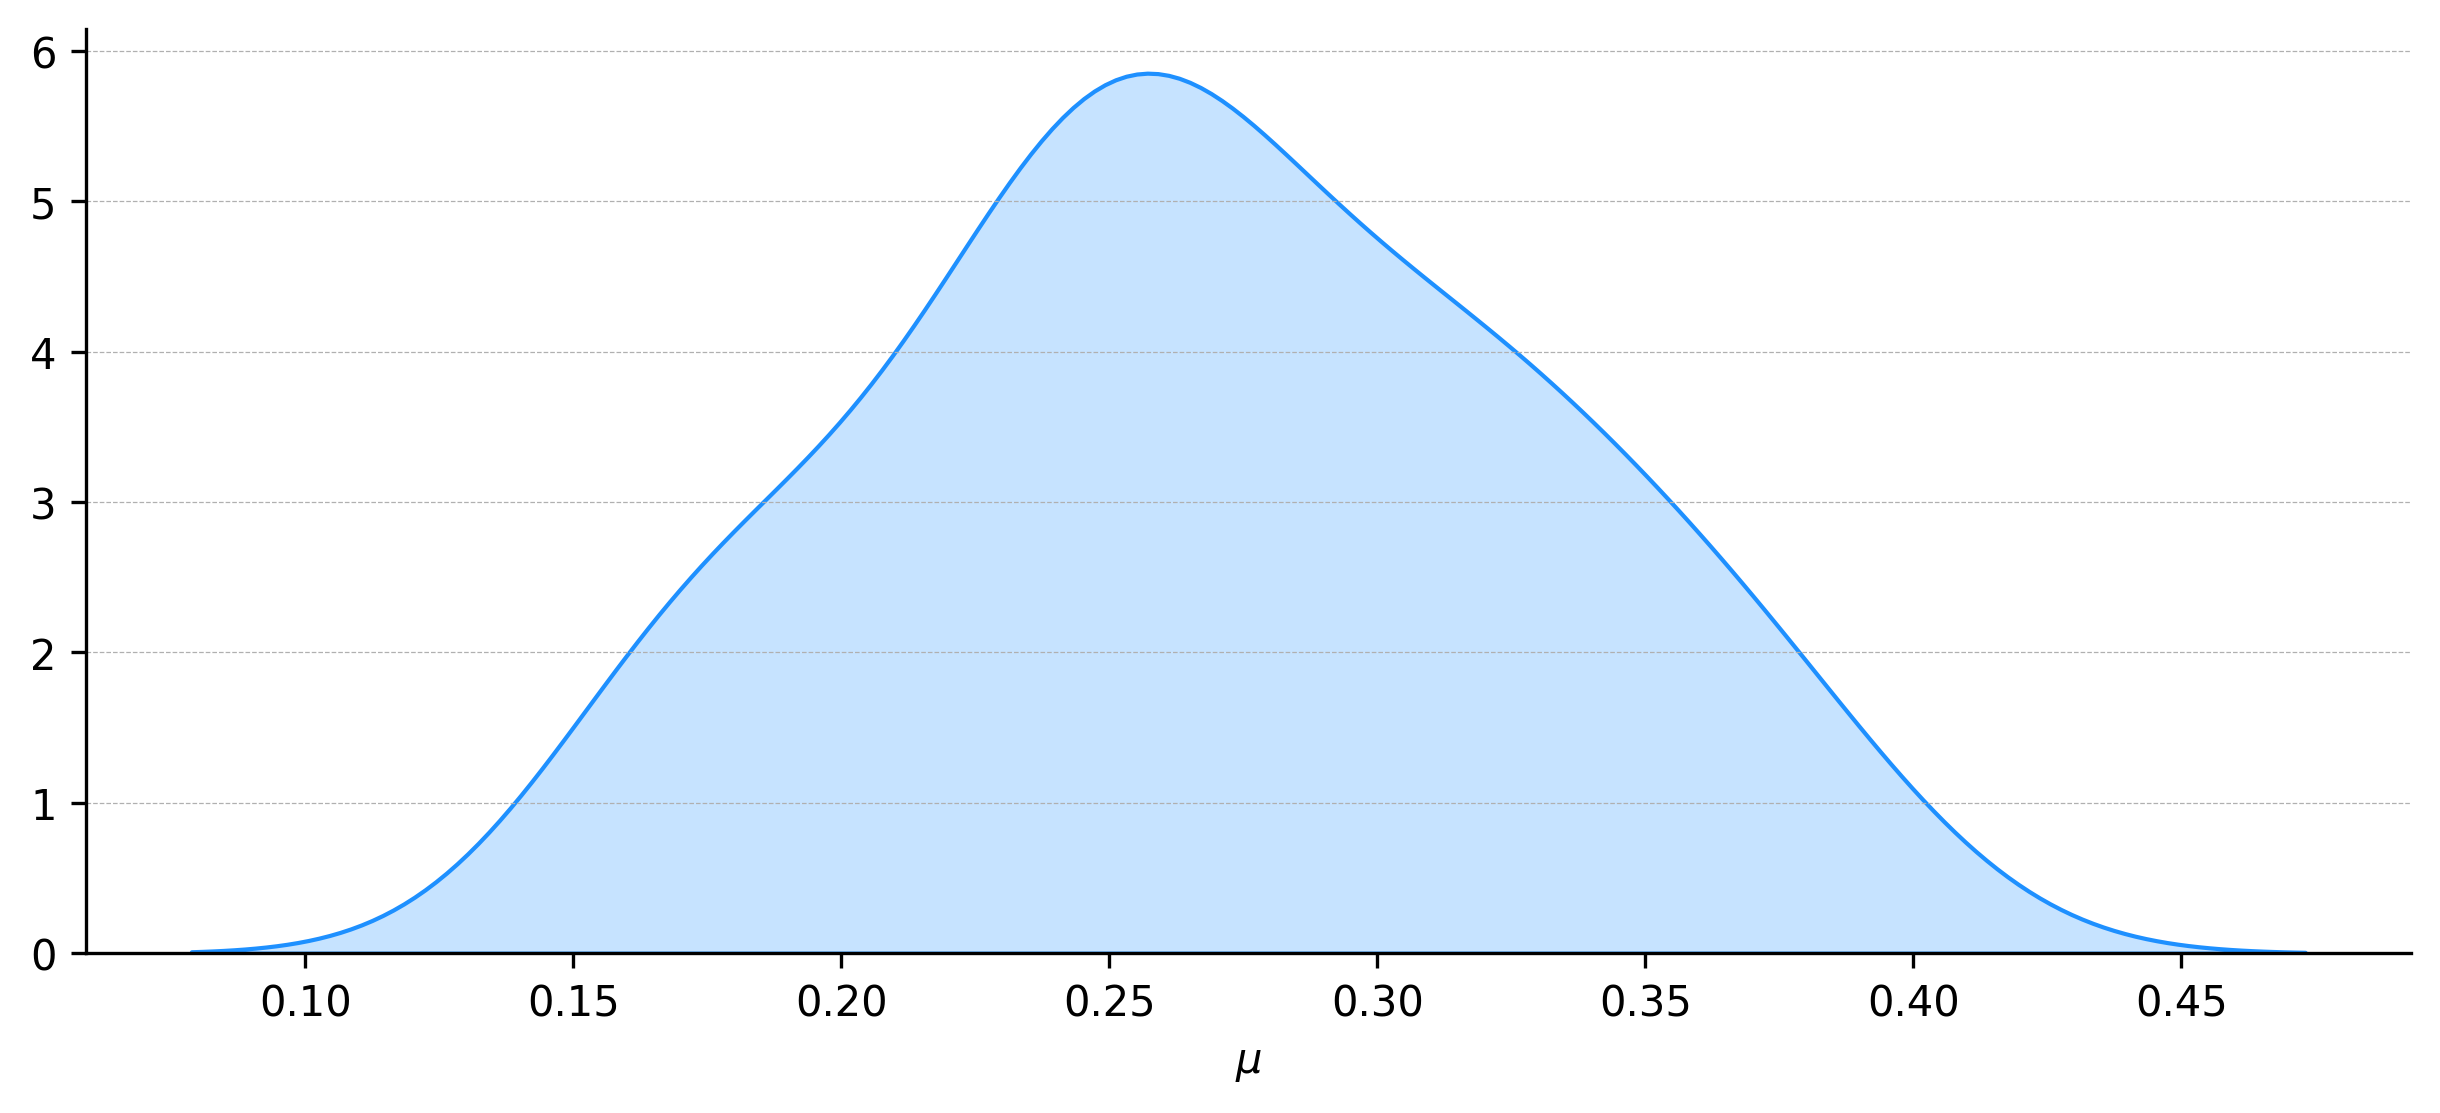

In [16]:
plot_posterior(results, "bet", kind="kde", prior_range=False, xlabel="$\\beta$")
plot_posterior(results, "mu", kind="kde", prior_range=False, xlabel="$\\mu$")

../epydemix/plotting.py:217: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df_posterior, x=parameter_x, y=parameter_y, ax=ax, fill=True, palette=palette, **kwargs)


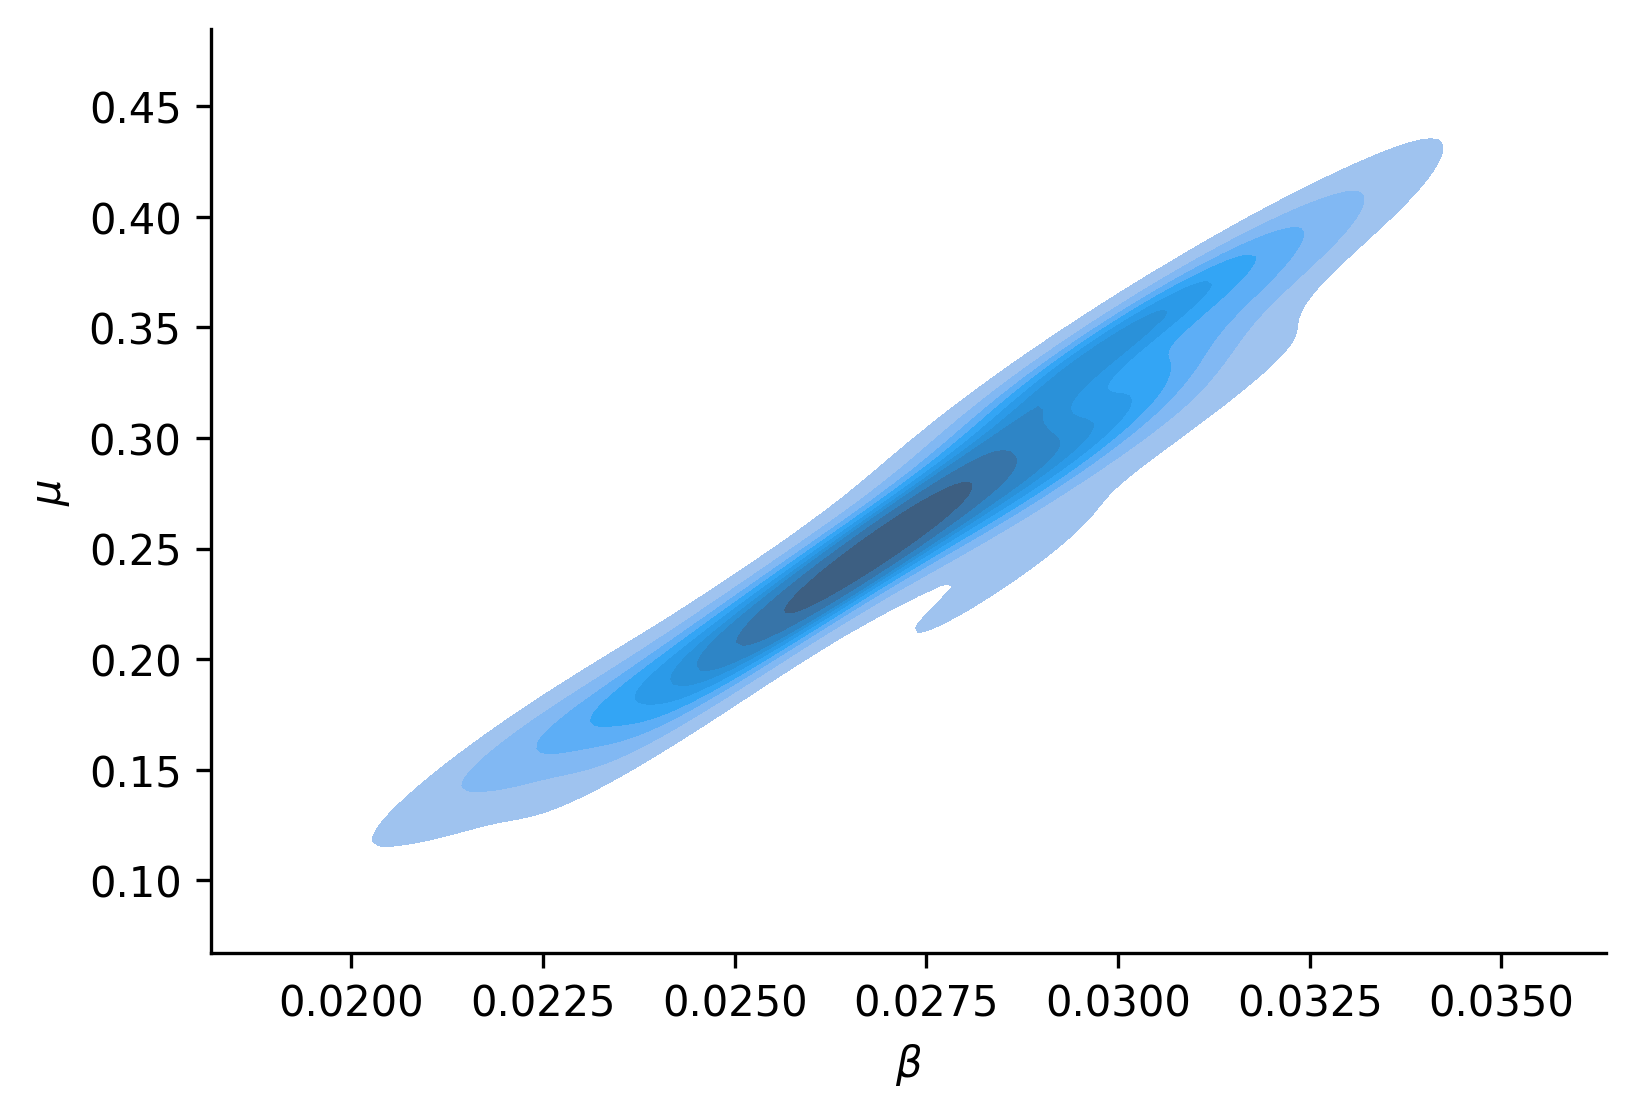

In [17]:
plot_posterior_2d(results, "bet", "mu", kind="kde", prior_range=False, xlabel="$\\beta$", ylabel="$\\mu$")